In [151]:
!pip3 install epitran
from google.colab import drive
drive.mount('/content/drive')
!pip install pymorphy2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 7.1MB 5.7MB/s 


In [234]:
import epitran
import pandas as pd
import numpy as np
import re
import networkx as nx
import sklearn
import pickle
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
load_model = pickle.load(open('model3_vow.sav', 'rb'))

from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import datasets

INFO:pymorphy2.opencorpora_dict.wrapper:Loading dictionaries from /usr/local/lib/python3.6/dist-packages/pymorphy2_dicts/data
INFO:pymorphy2.opencorpora_dict.wrapper:format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


In [6]:
verses = pd.read_csv('/content/drive/My Drive/verses.csv', sep = '\t')
    # verses = f.read().split('\n')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26,27,28,31,32,42,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [107]:
epi = epitran.Epitran('rus-Cyrl')
epi

In [108]:
epi.transliterate(u'мамулечка')

'mamulʲet͡ɕʲka'

In [0]:
with open ('words.csv', 'r', encoding = 'utf-8') as f:
    file = f.read().replace('?', '')
with open ('rules.csv', 'r', encoding = 'utf-8') as r:
    rules = r.read()

In [0]:
rules = rules.split('\n')
list_words = file.split(';\n')

# print(rules)
# print(list_words)

In [0]:
# ПОСТРОЕНИЕ ТРАНСКРИПЦИЙ В ЭПИТРАНЕ

# true_list_words = []
# list_words_ipa = []

# for two_words in list_words:
#     two_words = two_words.split(';')
#     true_list_words.append(two_words)
#     for word in two_words: 
#         word_ipa = epi.transliterate(word)
#         list_words_ipa.append(word_ipa)
# list_words_ipa

In [24]:
!pip install phonetic-algorithmIPA
from phonetic_algorithmIPA import ipa_distances
ipa = ipa_distances.PhoneticAlgorithmIPA()

In [0]:
# ПОСТРОЕНИЕ ТРАНСКРИПЦИЯ В phonetic-algorithmIPAБ
# ПОИСК РАССТОЯНИЯ ЛЕВЕНШТЕЙНА

# a = ipa.phonetic_transformer('words.csv', 'rules.csv', typ='Non LS')
# a

In [0]:
list_rules = []
for i in rules:
    list_rules.append(i.split(';'))

In [0]:
word = 'меня'

def zamena(word, index_letter, rule):
    # print(index_letter)
    letter = word[index_letter]
    if rule[0] == word[index_letter]:
        if rule[2] == '':
            word = word.replace(word[index_letter], rule[1])
            # index_letter += len(rule[1]) - len(rule[0])
            return word

        if rule[2][1] == word[index_letter+1] or rule[2][0] == word[index_letter-1]:
            if rule[2][1] == word[index_letter+1]:
                word = word.replace(word[index_letter], rule[1], 1)
                # index_letter += len(rule[1]) - len(rule[0])
                return word

        # print(rule[2][0] == word[index_letter-1])
        if rule[2][0] == word[index_letter-1]:
            print(rule[2][0])
            word = word.replace(word[index_letter], rule[1], 1)
            # index_letter += len(rule[1]) - len(rule[0])
            return word

        else:
            # print('e')
            # index_letter += len(rule[1]) - len(rule[0])
            return word

    else:
    # index_letter += len(rule[1]) - len(rule[0])
        return word


In [27]:
# РАЗБИЕНИЕ ПРАВИЛ ПО ОЧЕРЕДНОСТИ ПРИМЕНЕНИЯ К СЛОВУ

letter = 'ш'
def rule_for_letter(letter, rules):
    firstPrior_rules_for_letter = []
    SecondPrior_rules_for_letter = []
    for rule in rules:
        if rule[0] == letter and rule[2] != '':
            firstPrior_rules_for_letter.append(rule)
            # print('prior', firstPrior_rules_for_letter)
        elif rule[0] == letter and rule[2] == '':
            SecondPrior_rules_for_letter.append(rule)
            # print('second', SecondPrior_rules_for_letter)
    return firstPrior_rules_for_letter + SecondPrior_rules_for_letter

ru = rule_for_letter(letter, list_rules)
ru

[['ш', 'ʂ', '']]

In [28]:
# ФУНКЦИЯ ДЕЛАЕТ ТРАНСКРИПЦИЮ

def make_trans(word):
    word_base = word
    index_letter = 0
    for letter in word:
        prioritete_rule = rule_for_letter(letter, list_rules)
        # print(prioritete_rule, word)
        for i in prioritete_rule:
            # print(word, index_letter, i)
            word = zamena(word, index_letter, i)
        index_letter += 1 + len(word) - len(word_base)
        word_base = word
        # print(word)
    return word

make_trans('нѐосты̀лый#')

'nʲèostɨ̀lɨj#'

In [29]:
short_list = []
for two_w in list_words:
    j = two_w.split(';')
    short_list.append(j)
short_list[-2]

['домой', 'зимой']

In [0]:
big_list_trans = []
for pair in short_list[:-1]:
    for word in pair:
        two_w = make_trans(word +'#')
        big_list_trans.append(two_w)


In [0]:
#  with open('transcript.csv', 'w', encoding = 'utf-8') as f:
#   for pair in big_list_trans:
#     for w in pair:
#       f.write(w)
#     f.write('\n')
# with open('transcript.csv', 'r', encoding = 'utf-8') as f:
#   fi = f.read()
#   print(fi)

In [230]:
# СОЕДИНЯЕТ ДИАКРИТИКИ И ДРУГИЕ СПЕЦИАЛЬНЫЕ ЗНАКИ СО СЛОВАМИ, К КОТОРЫМ ОНИ ОТНОСЯТСЯ

diacritic = { "ʲ" : [ 'pos', { 'round': '+' } ], '̀' : [ 'pos', { 'round': '+' } ],  ")": [ 'betw', { 'round': '+' } ]}
# '̀' : [ 'pos', { 'round': '+' } ],
def find_diacr(word, letter, symbol):
    word = list(word)
    if symbol[0] == letter:
        if diacritic[symbol][0] == 'pos':
            pre = word[:word.index(letter) - 1]
            diacr = [word[word.index(letter) - 1] + word[word.index(letter)]]
            post = word[word.index(letter) + 1:]
            new_word = pre + diacr + post
            # print(new_word)
            return new_word, letter

# diacritic[symbol][0]
        elif diacritic[symbol][0] == 'pre':
            pre = word[:word.index(letter)]
            diacr = [word[word.index(letter)] + word[word.index(letter)+ 1 ]]
            post = word[word.index(letter) + 2:]
            new_word = pre + diacr + post
            letter = word[word.index(letter) + 2]
            # print(letter)
            return new_word, letter 
      
        elif diacritic[symbol][0] == 'betw':
            pre = word[:word.index(letter) - 1]
            diacr = [word[word.index(letter) - 1 ] + word[word.index(letter)] + word[word.index(letter)+ 1]]
            post = word[word.index(letter) + 2:]
            new_word = pre + diacr + post
            letter = word[word.index(letter) + 2]
            # print(new_word)
            return new_word, letter 

    else:
        return word, letter
    

print(find_diacr (['m', ')', 'e', 'n', 'a'], ')', ')'))

(['m)e', 'n', 'a'], 'n')


In [0]:
# РАЗДЕЛЯЕТ ВСЕ СЛОВА В ЛИСТЕ НА СЕГМЕНТЫ

def make_segments_list(big_list_trans):
    segments = []
    for word in big_list_trans:
        try:
            for letter in word:
                for symbol in diacritic.keys():
                    word, letter = find_diacr(word, letter, symbol)
        except ValueError:
            pass
        segments.append(word)
    return segments
# print(segments)

In [35]:
with open('puschkin.txt', 'r', encoding = 'utf-8') as f:
    file = f.read().lower()
    file = re.sub(r"[,!?.;:\-\'\"]", '', file)
stix = file.split('\n')
print(stix)

['взыграли подзeмные воды', 'встаeт за волною волна', 'печальная чeрная барка', 'сквозь сумрак багровый видна', 'злой дух парусами играет', 'стоѝт у руля сатана', 'в той барке погѝбшие души', 'вкусѝвшие грeшных утeх', 'вчера лишь их создало нeбо', 'сегодня ужалил их грeх', 'и плачут и чeрная барка', 'навeки увозит их всeх']


In [0]:
# ДОСТАЕТ СЛОВА В ЗОНЕ РИФМОВКИ

def find_last_words_l(stich):

    list_word_to_transc = []
    for i in stich:
        # print(i)
        if i != '':
            last_word = i.rstrip(' ').split(' ')[-1]
            if len(last_word) >= 4:
                word_to_transc = last_word
                list_word_to_transc.append(word_to_transc)
            else:
                word_to_transc = i.split(' ')[-2:]
                word_to_transc = ' '.join(word_to_transc)
                list_word_to_transc.append(word_to_transc)
        else:
            file.remove('')
    return list_word_to_transc

list_word_to_transc = find_last_words_l(stix)

In [0]:
# ДЕЛАЕТ ТРАНСКРИПЦИЮ ДЛЯ СПИСКА СЛОВ

def make_trans_for_list(list_word_to_transc):
    list_transc_push = []
    for i in list_word_to_transc:
        if ' ' in i:
            two_words_in_one = i.replace(' ' , '')
            list_transc_push.append(make_trans(two_words_in_one + '#'))
        else:
            list_transc_push.append(make_trans(i+'#'))
    return list_transc_push


In [0]:
segments = make_segments_list(make_trans_for_list(list_word_to_transc))

In [0]:
# ВЫДЕЛЯЕТ ПОСЛЕДНИЕ ЧЕТЫРЕ ЭЛЕМЕНТА В СЛОВЕ

def segments_four_last_func(segments):
    segments_four_last = ''
    count = 0
    for i in segments:
        str_word = ''
        str_word = ''.join(i[-5:-1:])
        if count % 2 == 0:
            segments_four_last += ''.join(str_word + ';')
            count += 1
        else:
            segments_four_last += ''.join(str_word + '\n')
            count += 1
    print(segments_four_last)
    return segments_four_last

In [0]:
# СЧИТАЕТ РАССТОЯНИЕ ПО ЛЕВЕНШТЕЙНУ МЕЖДУ ДВУМЯ СЛОВАМИ

def find_distance(str_word_first, str_word_second):
    with open('trans_four.csv', 'w', encoding = 'utf-8') as f:
        f.write(str_word_first + ';' + str_word_second)
    c = ipa.phonetic_distance('trans_four.csv', normalize = False)
    return c


In [0]:
# ФУНКЦИЯ ИЩЕТ ВОСЕМЬ БЛИЖАЙШИХ СТРОК К ЗАДАНОЙ СТРОКЕ


def find_eight_string(list_words, startword):
    if list_words.index(startword) == 0 or list_words.index(startword) == 1 or list_words.index(startword) == 2 or list_words.index(startword) == 3:
        befor = list_words[: list_words.index(startword)]
    else:
        befor = list_words[list_words.index(startword) -4  : list_words.index(startword)]
    after = list_words[list_words.index(startword) + 1 : list_words.index(startword) + 5]
    return befor, after

# ФУНКЦИЯ ВЫДАЕТ ДИСТАНЦИЮ МЕЖДУ СТАРТОВЫМ УЗЛОМ И УЗЛАМИ, СВЯЗАННЫМИ С НИМ  


def make_corteg_distance_for_nodes(startword, befor, after):
    list_corteg_distance_for_nodes = []
    startword_seg = make_segments_list(make_trans_for_list([startword]))[0]
    str_word_first = ''.join(startword_seg[-4:-1:])
    if befor != []:
        seg_befor = make_segments_list(make_trans_for_list(befor))
        for i in seg_befor:
            str_word_second = ''.join(i[-4:-1:])
            cort = (startword, befor[seg_befor.index(i)], find_distance(str_word_first, str_word_second))
            list_corteg_distance_for_nodes.append(cort)

    if after != []:
        seg_after = make_segments_list(make_trans_for_list(after))
        for i in seg_after:
            str_word_second = ''.join(i[-4:-1:])
            cort = (startword, after[seg_after.index(i)], find_distance(str_word_first, str_word_second))
            list_corteg_distance_for_nodes.append(cort)
    return list_corteg_distance_for_nodes

# лист восьми (спереди и сзади) ближайших соседей слова старт
# построение их транскрипции 
# нахождение растоянияния для каждой
# 
# записываю новый узел в граф если узел = минимальное растояние до этого слова
# подумать как оформить одиночные строки

In [0]:
# УСТАРЕВШЕЕ

# def find_min(node):
#     weight =None
#     min_dist = 3
#     cort_min = ()
#     for j in G.edges(node):
#         weight = G.get_edge_data(j[0], j[1])['weight']
#         if min_dist == 3:
#             min_dist = weight
#             cort_min = (min_dist, j)

#         elif min_dist > weight:
#             New_G.add_edge(j[0], j[1])
#             min_dist = weight
#             cort_min = (min_dist, j)
#     return cort_min 

In [43]:
# УСТАРЕВШЕЕ


# weight =None
# min_dist = 3  
# list_cort_edges_for_G = []

# New_G = nx.Graph()
# for i in list_word_to_transc:
#     New_G.add_node(i)
    
# for i in list_word_to_transc:
#     G=nx.Graph()
#     if type(i) == list:
#         i = ' '.join(i)
#     befor_startword, after_startword = find_eight_string(list_word_to_transc, i)
#     list_corteg_distance_for_node_i = make_corteg_distance_for_nodes(i, befor_startword, after_startword)
#     G.add_weighted_edges_from(list_corteg_distance_for_node_i)
# #     print(G.edges())
#     cort_min = find_min(i)
# #     print(cort_min, '\n', cort_min[1][0], cort_min[1][1])
#     list_cort_edges_for_G.append((cort_min[1][0], cort_min[1][1]))
# print(list_cort_edges_for_G)
# New_G.add_edges_from(list_cort_edges_for_G)


[('воды', 'волна'), ('волна', 'видна'), ('барка', 'волна'), ('видна', 'волна'), ('играет', 'утeх'), ('сатана', 'волна'), ('души', 'сатана'), ('утeх', 'всeх'), ('нeбо', 'души'), ('грeх', 'утeх'), ('барка', 'волна'), ('всeх', 'утeх')]


In [0]:
# pos = nx.spring_layout(New_G)
# nx.draw(New_G, pos, with_labels=True)

In [0]:
# ДАЛЬШЕ Я НАЧИНАЮ ПОДГОТОВКУ ДАННЫХ К ОБУЧЕНИЮ СВОЕЙ МОДЕЛЬКИ

In [0]:
with open ('priznakiV.txt', 'r') as f:
    priznaki = f.readlines()

In [47]:
# ПРИПИСЫВАЕТ ПРИЗНАКИ ЗВУКАМ, ВЫДАЕТ ЛИСТ С ЛИСТАМИ

list_priznaki = []
for i in priznaki:
    list_priznaki.append(i.split(';'))

def create_matrix_priz(list_priznaki, word):
    list_priz_for_word = []
    for letter in word[-4:-1:]:
        for i in list_priznaki:
            if letter == i[0]:
                list_priz_for_word.append(i[2:18])

    return list_priz_for_word

print(len(create_matrix_priz(list_priznaki, ['mʲ', 'e', 'nʲ', 'a', '#'])[0]))

16


In [49]:
# ДЕЛИТ СЛОВО НА СЕГМЕНТЫ

def make_segments_for_word(word):
    for letter in word:
        for symbol in diacritic.keys():
            word, letter = find_diacr(word, letter, symbol)
        # print(word)
    return word
make_segments_for_word('dnʲa#')

['d', 'nʲ', 'a', '#']

In [236]:
# ФУНКЦИЯ ВОЗВРАЩАЕТ ВЕКТОР В КОТОРОМ ЕДИНИЦАМИ УКАЗАНЫ ОБЩИЕ ЭЛЕМЕНТЫ, А НУЛЯМИ РАЗЛИЧНЫЕ

def matr_egal(matr1, matr2):
    list_egalite = []
    for i in range(len(matr1)):
        for j in range(len(matr1[i])):
            if matr1[i][j] == matr2[i][j]:
                list_egalite.append(1)
            else:
                list_egalite.append(0)
    return list_egalite

matr1 = [['-', '-', '-', '?', '+', '?', '-', '+', '?', '-', '-', '-', '-', '-', '+'], ['+', '+', '-', '?', '?', '-', '+', '+', '-', '+', '?', '?', '?', '?', '?']]

matr2 =  [['-', '-', '+', '+', '+', '?', '-', '-', '?', '-', '-', '-', '-', '-', '+'], ['+', '+', '-', '?', '?', '-', '+', '+', '-', '+', '?', '?', '?', '?', '?']]

len(matr_egal(matr1, matr2))


30

In [0]:
dataf = pd.read_csv('data_vectots.csv')

In [0]:
print(dataf.head())
dataf1 = np.copy(dataf)

   Unnamed: 0  0  1  2  3  4  5  6  7  8 ...  36  37  38  39  40  41  42  43  \
0          40  1  1  1  1  0  1  1  1  1 ...   1   1   1   1   1   1   1   1   
1          43  1  0  1  1  1  1  1  1  1 ...   1   1   1   1   1   1   1   1   
2          45  1  1  1  1  1  1  0  1  0 ...   1   1   1   1   1   1   1   1   
3          48  1  1  1  1  1  1  1  1  1 ...   1   1   1   1   1   1   1   1   
4          60  1  1  1  1  1  1  0  1  0 ...   1   1   1   1   1   1   1   1   

   44  45  
0   1   1  
1   0   1  
2   1   1  
3   1   1  
4   1   1  

[5 rows x 47 columns]


In [0]:
np.random.shuffle(dataf1)

In [0]:
np.random.shuffle(dataf1)
len(dataf1)
train = dataf1[:70000]
test = dataf1[70000:]

X_train = train[:,:45]
Y_train = train[ :,45]

X_test = test[:,:45]
Y_test = test[ :,45]
print(X_train, Y_train)

[[3469    1    1 ...,    1    1    1]
 [3661    1    1 ...,    1    1    1]
 [2454    0    1 ...,    1    1    1]
 ..., 
 [ 383    0    0 ...,    1    1    1]
 [  43    1    0 ...,    1    1    1]
 [ 823    0    0 ...,    1    1    1]] [1 1 1 ..., 1 0 1]


In [0]:
ridge = RidgeClassifier()
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])
parameters = dict(alpha = alphas)

clf = GridSearchCV(ridge, parameters, cv=5)
clf.fit(X_train, Y_train)

In [0]:
print(clf.best_score_)
print(clf.best_params_)
print(clf.best_estimator_)
print(clf.best_estimator_.alpha)

0.9186
{'alpha': 1.0}
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
1.0


In [0]:
answers = clf.best_estimator_.predict(X_test)
print(Y_test[:20])

['0' '0' '1' '1' '0' '1' '0' '1' '0' '0' '0' '1' '1' '1' '0' '0' '0' '0'
 '1' '1']


In [0]:
model = clf.best_estimator_
pickle.dump(model, open('model.sav', 'wb'))

In [0]:
nonr = np.array(nonr).reshape(1, -1)
print(X_test)
answers = clf.best_estimator_.predict(nonr)
print(answers)

[[0 0 0 ... 0 1 1]
 [1 1 0 ... 1 1 1]
 [1 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]]
['1']


In [0]:
(answers == Y_test).astype(int).mean()

0.9182763196697139

In [0]:
load_model = pickle.load(open('model3_vow.sav', 'rb'))

In [0]:
# ОСНОВНОЙ КОД, ДЕЛАЕТ БОЛЬШОЙ ДАТАФРЕЙМ, ПОЛУЧАЯ НА ВХОД ДВА СЛОВА И МЕТКУ РИФМКЮТСЯ ИЛИ НЕТ. ВОЗВРАЩАЕТ 
# ДАТАФРЕЙМ РАЗМЕРОМ N НА 46, ГДЕ N - КОЛЛИЧЕСТВО РИФМОВАННЫХ + НЕ РИФМРВАННЫХ ПАР СЛОВ

# НЕ ЗАПУСКАТЬ!!! ГРУЗИТСЯ ДОЛГОООО

# with open('dataslittle.csv', 'r', encoding = 'utf-8') as f:
#     data = f.readlines()

# dataf = pd.DataFrame(columns = range(0, 46))
# count_col = 1 

# for stroka in data:
#     three_words = stroka.replace('\n', '').split(';')
#     list_big = []
#     list_two_w_to_copare = []
#     for word in three_words:
#         if three_words.index(word) == 2:
#             pass
#         else:
#             seg = make_segments_for_word(make_trans(word + '#'))
#             list_two_w_to_copare.append(create_matrix_priz(list_priznaki, seg))
#     if len(list_two_w_to_copare[0]) < 3  or len(list_two_w_to_copare[1]) < 3:
#         pass
#     else:
#         print(count_col)
#         egal = matr_egal(list_two_w_to_copare[0], list_two_w_to_copare[1])
#         dataf.loc[count_col, 0:44] = egal
#         dataf.loc[count_col, 45] = three_words[-1]
#     count_col += 1
# dataf.to_csv('data_vectots.csv')

In [0]:
dataf.shape

(97128, 46)

In [0]:
def find_eight_string(list_words, startword, count_str):
    if count_str == 0 or count_str == 1 or count_str == 2 or count_str == 3:
        befor = list_words[: count_str]
    else:
        befor = list_words[count_str -4  : count_str]
    after = list_words[count_str + 1 :count_str + 5]
    return befor, after

In [0]:
# ПРОГА СОЗДАЕТ ВЕКТОР ПОХОЖЕСТИ ДВУХ ВЕКТОРОВ, КОТОРЫЙ ПОДАЕТСЯ НА ВХОД МОДЕЛИ

def pred_rythm(word1, word2, count_str, count_str2):
    tr = make_trans(word1 + '#')
    tr2 = make_trans(word2 + '#')

    tr_seg = make_segments_for_word(tr)
    tr_seg2 = make_segments_for_word(tr2)

    nonr = matr_egal(create_matrix_priz(list_priznaki, make_segments_for_word(tr)), create_matrix_priz(list_priznaki, make_segments_for_word(tr2)))
    nonr = np.array(nonr).reshape(1, -1)
    if load_model.predict(nonr) == ['1']:
        return word1 + ' ' + str(count_str), word2 + ' ' + str(count_str2)


In [0]:
def make_corteg_of_nodes_of_startword(startword, befor, after, list_corteg_of_nodes, count_str):
    if after != []:
        count_str2 = count_str + 1
        for i in after:
            cort = pred_rythm(startword, i, count_str, count_str2)
            if cort != None:
                list_corteg_of_nodes.append(cort)
            count_str2 += 1

    return list_corteg_of_nodes

In [0]:
# New_G = nx.Graph()
# list_corteg_of_nodes = []
# count_str = 0
# for i in list_word_to_transc:
#     G=nx.Graph()
#     if type(i) == list:
#         i = ' '.join(i)
#     befor_startword, after_startword = find_eight_string(list_word_to_transc, i, count_str)
#     list_corteg_of_nodes = make_corteg_of_nodes_of_startword(i, befor_startword, after_startword, list_corteg_of_nodes, count_str)
#     count_str += 1
# print(list_corteg_of_nodes)
# New_G.add_edges_from(list_corteg_of_nodes)
    

In [240]:
# СЧИТЫВАЕТ ИЗ ДАТАФРЕЙМА СО ВСЕМИ СТИХАМИ НЕКОТОРОЕ КОЛИЧЕСТВО СТРОК

stix = []
# print(verses.loc[:20, 'LineText'])
st = verses.loc[:20, 'LineText'].values.tolist()
for i in st:
    i = i.lower()
    i = re.sub(r"[,!?.;:\-\'\"]", '', i)
    stix.append(i)

print(stix) 

['друзья̀ на что̀ смуща̀ть ещѐ прах нѐосты̀лый', 'бессмѐртного̀ творца̀', 'пуска̀й парѝт любо̀вь над мѝрною̀ могѝлой', 'он блѝжних нѝкогда̀ не о̀горча̀л сердца̀', 'мѝлый зво̀нкий со̀ловѐй', 'на̀сладѝсь весно̀й своѐй', 'по̀й при я̀сностѝ лазу̀ри', 'что̀ до го̀ря что̀ до бу̀ри', 'мѝлый зво̀нкий со̀ловѐй', 'бы̀стро мѝнут со̀рок днѐй', 'мѝлый зво̀нкий со̀ловѐй', 'ты̀ поѐшь  журчѝт ручѐй', 'ѝ луна̀ всё по̀сребря̀ет', 'гдѐ твой го̀лос про̀бега̀ет', 'свѐтлой бы̀строю̀ струѐй', 'по̀й ты о̀тпоѐшь с весно̀й', 'мѝлый зво̀нкий со̀ловѐй', 'на̀живѐшь когда̀ детѐй', 'слу̀х пленя̀ть ты по̀забу̀дешь', 'хло̀пота̀ть нево̀льно бу̀дешь', 'нѐ до пѐсен у̀ж тогда̀']


In [225]:
# СОЗДАЕТ ГРАФ В КОТОРОМ УЗЛЫ - СЛОВА. РЕБРА СОЕДИНЯЮТ ДВА УЗЛА, ЕСЛИ ОНИ РИФМУЮТСЯ

New_G = nx.Graph()
list_word_to_transc = find_last_words_l(stix)
list_corteg_of_nodes = []
count_str = 0

for i in list_word_to_transc:
    G=nx.Graph()
    if type(i) == list:
        i = ' '.join(i)
    befor_startword, after_startword = find_eight_string(find_last_words_l(stix), i, count_str)
    list_corteg_of_nodes = make_corteg_of_nodes_of_startword(i, befor_startword, after_startword, list_corteg_of_nodes, count_str)
    count_str += 1
print(list_corteg_of_nodes)

New_G.add_edges_from(list_corteg_of_nodes)

[('нѐосты̀лый 0', 'могѝлой 2'), ('творца̀ 1', 'сердца̀ 3'), ('со̀ловѐй 4', 'своѐй 5'), ('со̀ловѐй 4', 'со̀ловѐй 8'), ('своѐй 5', 'со̀ловѐй 8'), ('своѐй 5', 'днѐй 9'), ('лазу̀ри 6', 'бу̀ри 7'), ('со̀ловѐй 8', 'днѐй 9'), ('со̀ловѐй 8', 'со̀ловѐй 10'), ('со̀ловѐй 8', 'ручѐй 11'), ('днѐй 9', 'со̀ловѐй 10'), ('днѐй 9', 'ручѐй 11'), ('со̀ловѐй 10', 'ручѐй 11'), ('со̀ловѐй 10', 'струѐй 14'), ('ручѐй 11', 'струѐй 14'), ('ручѐй 11', 'весно̀й 15'), ('по̀сребря̀ет 12', 'про̀бега̀ет 13'), ('струѐй 14', 'весно̀й 15'), ('струѐй 14', 'со̀ловѐй 16'), ('струѐй 14', 'детѐй 17'), ('весно̀й 15', 'со̀ловѐй 16'), ('весно̀й 15', 'детѐй 17'), ('со̀ловѐй 16', 'детѐй 17'), ('по̀забу̀дешь 18', 'бу̀дешь 19')]


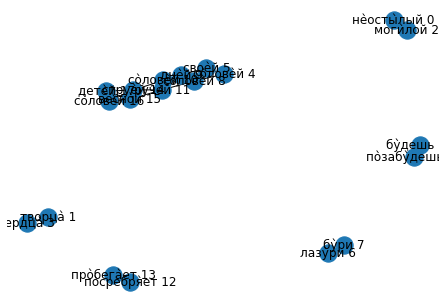

In [72]:
pos = nx.spring_layout(New_G)
nx.draw(New_G, pos, with_labels=True)

In [0]:
# ОПРЕДЕЛЯЕТ ВИДЫ РИФМЫ

def detect_tochn(word1, word2):
    if word1[-4:] == word2[-4:]:
        return 'точная'
    else:
        return 'неточная'

def detect_accent(word1, word2):
    Vowels = re.findall(r'[а,и,ю,я,е,э,о,ы,у,̀ ]', word1)
    if Vowels[-1] == '̀':
        return 'мужская'
    elif Vowels[-2] == '̀':
        return 'женская'
    elif Vowels[-3] == '̀':
        return 'дактилическая'
    elif Vowels[-4] == '̀':
        return 'гипердактилическая'

def detect_odnorodn(word1, word2):
    mor_word1 = morph.parse(word1)[0]
    mor_word2 = morph.parse(word2)[0]
    # print(mor_word1.tag.POS)
    if mor_word1.tag.POS == mor_word2.tag.POS:
        return 'однородная'
    elif mor_word1.tag.POS != mor_word2.tag.POS and mor_word2.tag.POS not in ['PRCL', 'INTJ', 'CONJ', 'PREP'] and mor_word2.tag.POS not in ['PRCL', 'INTJ', 'CONJ', 'PREP']:
        return 'разнородная'
    else:
        return 'составная'


In [246]:
# ОПРЕДЕЛЕНИЕ РИФМЫ, ЗАПИСЬ В ДАТАФРЕЙМ (МОЖНО ДОБАВИТЬ ОПРЕДЕЛЕНИЕ РИФМОВКИ)

def detec_ry(New_G):
    count_num_col = 0
    for edge in New_G.edges():
        # print(edge)
        word1 = edge[0].split()[0]
        word2 = edge[1].split()[0]
        ry_accent = detect_accent(word1, word2)
        ry_tocnhn = detect_tochn(word1, word2)
        ry_odnor = detect_odnorodn(word1, word2)
        # print(edge, ry_accent, ry_tocnhn, ry_odnor)
        df_detec_ry.loc[count_num_col] = word1, word2, ry_accent, ry_tocnhn, ry_odnor
        count_num_col += 1

col = ['слово1', 'слово2', 'рифма_ударение', 'рифма_точная', 'рифма_однородность']
df_detec_ry = pd.DataFrame(columns = col)
detec_ry(New_G)

print(df_detec_ry)


          слово1       слово2 рифма_ударение рифма_точная рифма_однородность
0    нѐосты̀лый     могѝлой        женская     неточная        разнородная
1        творца̀      сердца̀        мужская     неточная         однородная
2      со̀ловѐй       своѐй        мужская     неточная         однородная
3      со̀ловѐй    со̀ловѐй        мужская       точная         однородная
4         своѐй    со̀ловѐй        мужская     неточная         однородная
5         своѐй        днѐй        мужская     неточная         однородная
6      со̀ловѐй        днѐй        мужская     неточная         однородная
7      со̀ловѐй    со̀ловѐй        мужская       точная         однородная
8      со̀ловѐй       ручѐй        мужская     неточная         однородная
9          днѐй    со̀ловѐй        мужская     неточная         однородная
10         днѐй       ручѐй        мужская     неточная         однородная
11       лазу̀ри        бу̀ри        женская       точная         однородная